# MACS 30150
## Problem Set 5
## Songrun He

### Problem 1

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [58]:
dt = pd.read_csv('data/incomes.txt', names = ['incomes'])
incomes = dt['incomes']
incomes.describe()

count       200.000000
mean      85276.823606
std       18037.692869
min       47628.560636
25%       71850.308175
50%       83864.444560
75%       96059.995074
max      139079.351549
Name: incomes, dtype: float64

### (a)
Plot a histogram of percentages of the income.txt data with 30 bins.

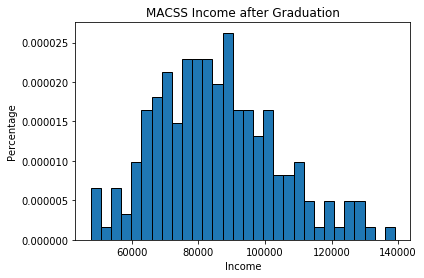

In [59]:
bins = 30
plt.hist(incomes, bins, density = True, edgecolor = 'k')
plt.xlabel('Income')
plt.ylabel('Percentage')
plt.title('MACSS Income after Graduation')
plt.show()

### (b)
(1) Estimate the parameters of the lognormal distribution by generalized method of moments. Use the average income and standard deviation of income as your two moments. Use the identity matrix as your weighting matrix.

(2) Plot your estimated lognormal PDF against the histogram.

(3) Report the value of your GMM criterion function at the estimated parameter values.

(4) Report and compare your two data moments against your two model moments at the estimated parameter values.

In [60]:
from scipy.stats import lognorm
import scipy.optimize as opt

def log_normal_pdf(xvals, mu, sigma):
    return lognorm.pdf(xvals, s = abs(sigma), scale = np.exp(mu))

def data_moments(xvals):
    mean = xvals.mean()
    std = xvals.std()
    return mean, std

def model_moments(mu, sigma):
    mean = np.exp(mu + (sigma**2)/2)
    std = np.sqrt((np.exp(sigma**2)-1)*np.exp(2*mu + sigma**2))
    return mean, std

def err_vec(xvals, mu, sigma, simple = False):
    mean_data, std_data = data_moments(xvals)
    moment_data = np.array([[mean_data], [std_data]])
    mean_model, std_model = model_moments(mu, sigma)
    moment_model = np.array([[mean_model],[std_model]])
    if simple:
        err_vec = moment_model - moment_data
    else:
        err_vec = (moment_model - moment_data)/moment_data        
    return err_vec

def criterion(params, *args):
    mu, sigma = params
    xvals, W = args
    err = err_vec(xvals, mu, sigma)
    val = err.T @ W @ err
    return val 

mu_i = 11
sigma_i = 0.5
params_init = np.array([mu_i, sigma_i])
W = np.eye(2)
args = (incomes, W)
results = opt.minimize(criterion, params_init, args, tol = 1e-14,
                      method = 'L-BFGS-B', bounds = ((1e-10, None), (1e-10, None)))
mu_1, sigma_1 = results.x

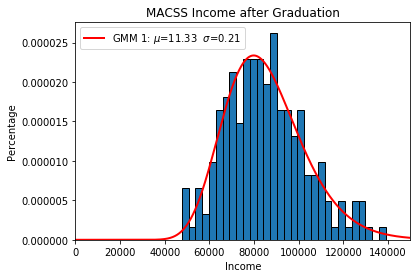

In [61]:
bins = 30
plt.hist(incomes, bins, density = True, edgecolor = 'k')
plt.xlabel('Income')
plt.ylabel('Percentage')
plt.title('MACSS Income after Graduation')
plt.xlim([0,150000])


x_arr = np.linspace(0, 150000, 200000)
plt.plot(x_arr, log_normal_pdf(x_arr, mu_1, sigma_1), 
        linewidth = 2, color = 'r', label = f'GMM 1: $\mu$={round(mu_1, 2)}  $\sigma$={round(sigma_1, 2)}')
plt.legend(loc = 'upper left')
plt.show()

In [62]:
print('mu_1 = ', mu_1, 'sigma_1 = ', sigma_1)
print('The sample mean is:', data_moments(incomes)[0])
print('The model mean is:', model_moments(mu_1, sigma_1)[0])
print('The sample standard deviation is:', data_moments(incomes)[1])
print('The model standard deviation is:', model_moments(mu_1, sigma_1)[1])
print('The value of GMM criterion function at the estimated parameter values is:', results.fun)
err1 = err_vec(incomes, mu_1, sigma_1).reshape(2,)
print('Error vector = ', err1)

mu_1 =  11.33177378997555 sigma_1 =  0.209209077091322
The sample mean is: 85276.82360625808
The model mean is: 85276.82504586459
The sample standard deviation is: 18037.692869371564
The model standard deviation is: 18037.692396839542
The value of GMM criterion function at the estimated parameter values is: [[9.71266031e-16]]
Error vector =  [ 1.68815681e-08 -2.61969213e-08]


### (c)
(1) Perform the two-step GMM estimator by using your estimates from part (b) with two moments to generate an estimator for the variance covariance matrix.

(2) Use the estimator to get the two-step estimator for the optimal weighting matrix

(3) Report your estimates as well as the criterion function value at these estimates.

(4) Plot your estimated lognormal PDF against the histogram from part (a) and the estimated PDF from part (b).

(5) Report and compare your two data moments against your two model moments at the estimated parameter values.

In [63]:
import numpy.linalg as lin
def err_mat(xvals, mu, sigma, simple = False):
    R = 2
    N = len(xvals)
    mat = np.zeros((R,N))
    mean_model, std_model = model_moments(mu, sigma)
    if simple:
        mat[0, :] = xvals - mean_model
        mat[1, :] = abs(mean_model - xvals) - std_model
    else:
        mat[0, :] = (xvals - mean_model) / xvals
        mat[1, :] = (abs(mean_model - xvals) - std_model) / abs(mean_model - xvals)
    return mat

err_mat = err_mat(incomes, mu_1, sigma_1)
Cov = (1/incomes.shape[0]) * (err_mat @ err_mat.T) 
W_2 = lin.inv(Cov)
print("The variance covariance matrix:\n", Cov)
print("The two-step estimator for \
the optimal weighting matrix:\n", W_2)

The variance covariance matrix:
 [[5.30804085e-02 6.48056438e-03]
 [6.48056438e-03 1.33462679e+04]]
The two-step estimator for the optimal weighting matrix:
 [[ 1.88393437e+01 -9.14784419e-06]
 [-9.14784419e-06  7.49273178e-05]]


In [64]:
mu_i = 11
sigma_i = 0.5
params_init = np.array([mu_i, sigma_i])
args = (incomes, W_2)
results2 = opt.minimize(criterion, params_init, args, tol = 1e-14,
                       method = 'L-BFGS-B', bounds = ((1e-10, None), (1e-10, None)))
mu_2, sigma_2 = results2.x
print('mu_2 = ', mu_2, 'sigma_2 = ', sigma_2)
print('The sample mean is:', data_moments(incomes)[0])
print('The model mean is:', model_moments(mu_2, sigma_2)[0])
print('The sample standard deviation is:', data_moments(incomes)[1])
print('The model standard deviation is:', model_moments(mu_2, sigma_2)[1])
print('The value of GMM criterion function at the estimated parameter values is:', results2.fun)
err2 = err_vec(incomes, mu_2, sigma_2).reshape(2,)
print('Error vector = ', err2)

mu_2 =  11.331771944019389 sigma_2 =  0.20921779510981567
The sample mean is: 85276.82360625808
The model mean is: 85276.8231672541
The sample standard deviation is: 18037.692869371564
The model standard deviation is: 18038.4602243296
The value of GMM criterion function at the estimated parameter values is: [[1.36106757e-13]]
Error vector =  [-5.14798704e-09  4.25417465e-05]


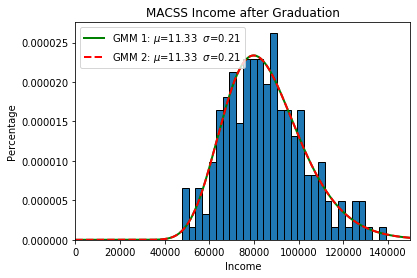

In [65]:
bins = 30
plt.hist(incomes, bins, density = True, edgecolor = 'k')
plt.xlabel('Income')
plt.ylabel('Percentage')
plt.title('MACSS Income after Graduation')
plt.xlim([0,150000])


x_arr = np.linspace(0, 150000, 200000)
plt.plot(x_arr, log_normal_pdf(x_arr, mu_1, sigma_1), 
        linewidth = 2, color = 'g', label = f'GMM 1: $\mu$={round(mu_1, 2)}  $\sigma$={round(sigma_1, 2)}')
plt.plot(x_arr, log_normal_pdf(x_arr, mu_2, sigma_2), 
        linewidth = 2, color = 'r', label = f'GMM 2: $\mu$={round(mu_2, 2)}  $\sigma$={round(sigma_2, 2)}', ls = '--')
plt.legend(loc = 'upper left')
plt.show()

### (d)
(1) Estimate the lognormal PDF to fit the data by GMM using different moments.

(2) Plot your estimated lognormal PDF against the histogram from part (a).

(3) Report the value of your GMM criterion function at the estimated parameter values. Report and compare your three data moments against your three model moments at the estimated parameter values.

In [66]:
import scipy.integrate as intgr
from scipy.stats import lognorm

def data_moments2(xvals):
    pct1 = xvals[xvals < 75000].shape[0]/xvals.shape[0]
    pct2 = xvals[(xvals >= 75000) & (xvals <= 100000)].shape[0]/xvals.shape[0]
    pct3 = xvals[xvals > 100000].shape[0]/xvals.shape[0]
    return pct1, pct2, pct3

def model_moments2(mu, sigma):
    pct1 = (lognorm.cdf(75000, s=sigma, scale=np.exp(mu)) -
             lognorm.cdf(0, s=sigma, scale=np.exp(mu)))
    pct2 = (lognorm.cdf(100000, s=sigma, scale=np.exp(mu)) -
             lognorm.cdf(75000, s=sigma, scale=np.exp(mu)))
    pct3 = (lognorm.cdf(np.inf, s=sigma, scale=np.exp(mu)) -
             lognorm.cdf(100000, s=sigma, scale=np.exp(mu)))
    return pct1, pct2, pct3

def err_vec2(xvals, mu, sigma, simple = False):
    pct1_dt, pct2_dt, pct3_dt = data_moments2(xvals)
    moments_dt = np.array([[pct1_dt], [pct2_dt], [pct3_dt]])
    pct1_md, pct2_md, pct3_md = model_moments2(mu, sigma)
    moments_md = np.array([[pct1_md], [pct2_md], [pct3_md]])
    if simple:
        err_vec = moments_md - moments_dt
    else:
        err_vec = (moments_md - moments_dt)/moments_dt
    
    return err_vec

def criterion2(params, *args):
    mu, sigma = params
    xvals, W = args
    err = err_vec2(xvals, mu, sigma)
    crit_val = err.T @ W @ err
    return crit_val

mu_i = 11
sigma_i = 0.5
params_i = np.array([mu_i, sigma_i])
W = np.eye(3)
args = (incomes, W)
results3 = opt.minimize(criterion2, params_i, args, tol = 1e-14,
                        method = 'L-BFGS-B', bounds = ((1e-10, None), (1e-10, None)))
mu_3, sigma_3 = results3.x

In [67]:
print('mu_3 = ', mu_3, 'sigma_3 = ', sigma_3)
print('The sample pct1:', data_moments2(incomes)[0])
print('The model pct1:', model_moments2(mu_3, sigma_3)[0])
print('The sample pct2 is:', data_moments2(incomes)[1])
print('The model pct2 is:', model_moments2(mu_3, sigma_3)[1])
print('The sample pct3 is:', data_moments2(incomes)[2])
print('The model pct3 is:', model_moments2(mu_3, sigma_3)[2])
print('The value of GMM criterion function at the estimated parameter values is:', results3.fun)
err3 = err_vec2(incomes, mu_3, sigma_3).reshape(3,)
print('Error vector = ', err3)

mu_3 =  11.335681327424783 sigma_3 =  0.21059845372069577
The sample pct1: 0.3
The model pct1: 0.30000000363266754
The sample pct2 is: 0.5
The model pct2 is: 0.5000000058543155
The sample pct3 is: 0.2
The model pct3 is: 0.19999999051301698
The value of GMM criterion function at the estimated parameter values is: [[2.53378848e-15]]
Error vector =  [ 1.21088919e-08  1.17086310e-08 -4.74349152e-08]


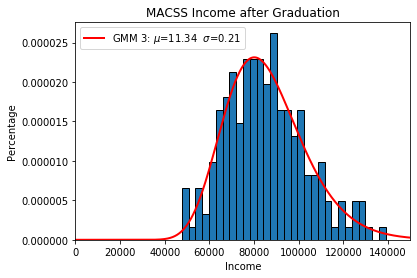

In [68]:
bins = 30
plt.hist(incomes, bins, density = True, edgecolor = 'k')
plt.xlabel('Income')
plt.ylabel('Percentage')
plt.title('MACSS Income after Graduation')
plt.xlim([0,150000])

x_arr = np.linspace(0, 150000, 200000)
plt.plot(x_arr, log_normal_pdf(x_arr, mu_3, sigma_3), 
        linewidth = 2, color = 'r', label = f'GMM 3: $\mu$={round(mu_3, 2)}  $\sigma$={round(sigma_3, 2)}')
plt.legend(loc = 'upper left')
plt.show()

### (e)

In [69]:
def err_mat2(xvals, mu, sigma, simple = True):
    R = 3
    N = len(xvals)
    mat = np.zeros((R,N))
    pct1_md, pct2_md, pct3_md = model_moments2(mu, sigma)
    if simple:
        pct1_dt = xvals < 75000
        mat[0,:] = pct1_dt - pct1_md
        pct2_dt = (xvals >= 75000) & (xvals < 100000)
        mat[1,:] = pct2_dt - pct2_md
        pct3_dt = (xvals >= 100000)
        mat[2,:] = pct3_dt - pct3_md
    else:
        pct1_dt = xvals < 75000
        mat[0,:] = (pct1_dt - pct1_md)/pct1_md
        pct2_dt = (xvals >= 75000) & (xvals < 100000)
        mat[1,:] = (pct2_dt - pct2_md)/pct2_md
        pct3_dt = (xvals >= 100000)
        mat[2,:] = (pct3_dt - pct3_md)/pct3_md
    return mat

err_mat2 = err_mat2(incomes, mu_3, sigma_3)
Cov = (1 / incomes.shape[0]) * (err_mat2 @ err_mat2.T)
W = lin.pinv(Cov)

print("The variance covariance matrix:\n", Cov)
print("The two-step estimator for \
the optimal weighting matrix:\n", W)

The variance covariance matrix:
 [[ 0.21 -0.15 -0.06]
 [-0.15  0.25 -0.1 ]
 [-0.06 -0.1   0.16]]
The two-step estimator for the optimal weighting matrix:
 [[ 2.25925926 -0.62962963 -1.62962963]
 [-0.62962963  1.81481481 -1.18518519]
 [-1.62962963 -1.18518519  2.81481481]]


In [70]:
mu_i = 11
sigma_i = 0.5
params_init = np.array([mu_i, sigma_i])
args = (incomes, W)
results4 = opt.minimize(criterion2, params_init, args, tol = 1e-14,
                       method = 'L-BFGS-B', bounds = ((1e-10, None), (1e-10, None)))
mu_4, sigma_4 = results4.x
print('mu_4 = ', mu_4, 'sigma_4 = ', sigma_2)
print('The sample pct1:', data_moments2(incomes)[0])
print('The model pct1:', model_moments2(mu_4, sigma_4)[0])
print('The sample pct2 is:', data_moments2(incomes)[1])
print('The model pct2 is:', model_moments2(mu_4, sigma_4)[1])
print('The sample pct3 is:', data_moments2(incomes)[2])
print('The model pct3 is:', model_moments2(mu_4, sigma_4)[2])
print('The value of GMM criterion function at the estimated parameter values is:', results4.fun)
err4 = err_vec2(incomes, mu_4, sigma_4).reshape(3,)
print('Error vector = ', err4)

mu_4 =  11.335681328573827 sigma_4 =  0.20921779510981567
The sample pct1: 0.3
The model pct1: 0.3000000073611173
The sample pct2 is: 0.5
The model pct2 is: 0.49999999332865186
The sample pct3 is: 0.2
The model pct3 is: 0.19999999931023082
The value of GMM criterion function at the estimated parameter values is: [[2.29579956e-15]]
Error vector =  [ 2.45370578e-08 -1.33426963e-08 -3.44884593e-09]


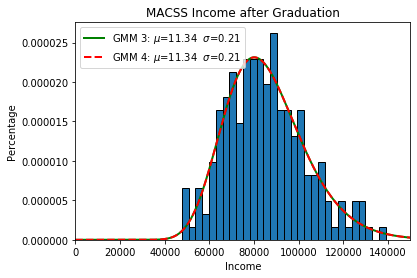

In [71]:
bins = 30
plt.hist(incomes, bins, density = True, edgecolor = 'k')
plt.xlabel('Income')
plt.ylabel('Percentage')
plt.title('MACSS Income after Graduation')
plt.xlim([0,150000])


x_arr = np.linspace(0, 150000, 200000)
plt.plot(x_arr, log_normal_pdf(x_arr, mu_3, sigma_3), 
        linewidth = 2, color = 'g', label = f'GMM 3: $\mu$={round(mu_3, 2)}  $\sigma$={round(sigma_3, 2)}')
plt.plot(x_arr, log_normal_pdf(x_arr, mu_4, sigma_4), 
        linewidth = 2, color = 'r', label = f'GMM 4: $\mu$={round(mu_4, 2)}  $\sigma$={round(sigma_4, 2)}', ls = '--')
plt.legend(loc = 'upper left')
plt.show()

### (f)

We can not directly compare the models using the criterion function because in each case, either the vector of moments or the weighting matrix is different. The criterion functions are fundamentally different.  

Besides, the solution to the four models are quite close. We can see that in a sense, the GMM estimates of the distribution is quite robust across different moments specificaiton.

If we have to pick a best, I think conceptually the last one is the best. Because it incorporates more moments condition into consideration, and takes into consideration the correlation as well as heteroskedasticity of moment estimators through the weighting matrix. It also matches the data quite well. Therefore, we argue that it is the best GMM estimator.

### Problem 1

In [72]:
import pandas as pd

In [73]:
df = pd.read_csv('data/sick.txt').astype('float64')
df.describe()

,sick,age,children,avgtemp_winter
count,200.000000,200.000000,200.000000,200.000000
mean,1.008600,40.683850,1.674950,44.041250
std,0.504222,11.268686,0.969761,11.101977
min,0.040000,12.810000,0.000000,16.500000
25%,0.650000,33.967500,0.970000,36.112500
50%,0.960000,41.015000,1.560000,43.300000
75%,1.322500,47.750000,2.322500,52.172500
max,2.800000,74.890000,4.960000,68.600000


### (a)

In [74]:
def err_vec(y, x1, x2, x3, b0, b1, b2, b3, simple = True):
    y_hat = b0 + b1*x1 + b2*x2 + b3*x3
    if simple:
        return y - y_hat
    else:
        return (y - y_hat)/y

def crit(params, *args):
    b0, b1, b2, b3 = params
    y, x1, x2, x3, W = args
    err = err_vec(y, x1, x2, x3, b0, b1, b2, b3)
    val = err.T @ W @ err
    return val

In [75]:
params_init = np.array([1, 0, 0, 0])
W = np.eye(df['sick'].size)
args = (df.sick, df.age, df.children, df.avgtemp_winter, W)
results_2a = opt.minimize(crit, params_init, args,tol=1e-14, method='L-BFGS-B')
b0, b1, b2, b3 = results_2a.x
val_crit = results_2a.fun
print("Estimate of b0:",b0)
print("Estimate of b1:",b1)
print("Estimate of b2:",b2)
print("Estimate of b3:",b3)
print('Value of GMM criterion function:',val_crit)

Estimate of b0: 0.2516448636180223
Estimate of b1: 0.012933469667256711
Estimate of b2: 0.40050098511048643
Estimate of b3: -0.009991708483433188
Value of GMM criterion function: 0.00182128980560192
